In [1]:
# import requests
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

import time
import json
import requests
import numpy as np
import pandas as pd

import requests
from requests.auth import HTTPBasicAuth


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#credentials = json.loads(open('credentials.json').read())
#authentication = HTTPBasicAuth(credentials['username'], credentials['password'])

token = "your-token"

headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'PosterisIT',
        'Authorization': 'token ' + token
    }
)

In [3]:
data = requests.get('https://api.github.com/users/Oraci', headers=headers)
data = data.json()
data

{'avatar_url': 'https://avatars.githubusercontent.com/u/6287732?v=4',
 'bio': None,
 'blog': '',
 'company': 'Spintec',
 'created_at': '2013-12-30T16:14:26Z',
 'email': None,
 'events_url': 'https://api.github.com/users/Oraci/events{/privacy}',
 'followers': 8,
 'followers_url': 'https://api.github.com/users/Oraci/followers',
 'following': 8,
 'following_url': 'https://api.github.com/users/Oraci/following{/other_user}',
 'gists_url': 'https://api.github.com/users/Oraci/gists{/gist_id}',
 'gravatar_id': '',
 'hireable': None,
 'html_url': 'https://github.com/Oraci',
 'id': 6287732,
 'location': 'Blumenau',
 'login': 'Oraci',
 'name': 'Oraci Izidoro Corrêa',
 'node_id': 'MDQ6VXNlcjYyODc3MzI=',
 'organizations_url': 'https://api.github.com/users/Oraci/orgs',
 'public_gists': 0,
 'public_repos': 13,
 'received_events_url': 'https://api.github.com/users/Oraci/received_events',
 'repos_url': 'https://api.github.com/users/Oraci/repos',
 'site_admin': False,
 'starred_url': 'https://api.github

In [4]:
print("Name: {}".format(data['name']))
print("Email: {}".format(data['email']))
print("Location: {}".format(data['location']))
print("Public repos: {}".format(data['public_repos']))
print("Public gists: {}".format(data['public_gists']))
print("About: {}".format(data['bio']))

Name: Oraci Izidoro Corrêa
Email: None
Location: Blumenau
Public repos: 13
Public gists: 0
About: None


In [5]:
#iterate over alll repositories
url = data['repos_url']
page_no = 1
repos_data = []

while (True):
    response = requests.get(url, headers=headers)
    response = response.json()
    repos_data = repos_data + response
    repos_fetched = len(response)
    print("Total repositories fetched: {}".format(repos_fetched))
    if (repos_fetched == 30):
        page_no = page_no + 1
        url = data['repos_url'] + '?page=' + str(page_no)
    else:
        break

Total repositories fetched: 13


In [6]:
repos_information = []
for i, repo in enumerate(repos_data):
    data = []
    data.append(repo['id'])
    data.append(repo['name'])
    data.append(repo['description'])
    data.append(repo['created_at'])
    data.append(repo['updated_at'])
    data.append(repo['owner']['login'])
    data.append(repo['license']['name'] if repo['license'] != None else None)
    data.append(repo['has_wiki'])
    data.append(repo['forks_count'])
    data.append(repo['open_issues_count'])
    data.append(repo['stargazers_count'])
    data.append(repo['watchers_count'])
    data.append(repo['url'])
    data.append(repo['commits_url'].split("{")[0])
    data.append(repo['url'] + '/languages')
    repos_information.append(data)

In [7]:
repos_df = pd.DataFrame(repos_information, columns = ['Id', 'Name', 'Description', 'Created on', 'Updated on', 
                                                      'Owner', 'License', 'Includes wiki', 'Forks count', 
                                                      'Issues count', 'Stars count', 'Watchers count',
                                                      'Repo URL', 'Commits URL', 'Languages URL'])


In [8]:
for i in range(repos_df.shape[0]):
#     time.sleep(2)
    response = requests.get(repos_df.loc[i, 'Languages URL'], headers=headers)
    response = response.json()
#     print(i, response)
    if response != {}:
        languages = []
        for key, value in response.items():
            languages.append(key)
        languages = ', '.join(languages)
        repos_df.loc[i, 'Languages'] = languages
    else:
        repos_df.loc[i, 'Languages'] = ""
        
# repos_df.to_csv('repos_info.csv', index = False)

In [9]:
repos_df

,Id,Name,Description,Created on,Updated on,Owner,License,Includes wiki,Forks count,Issues count,Stars count,Watchers count,Repo URL,Commits URL,Languages URL,Languages
0,213266863,aircnc,Rocketseat (OmniStack Week 9) - AirCNC (ReactJS),2019-10-07T00:40:35Z,2019-10-31T01:02:48Z,Oraci,None,True,0,9,0,0,https://api.github.com/repos/Oraci/aircnc,https://api.github.com/repos/Oraci/aircnc/commits,https://api.github.com/repos/Oraci/aircnc/lang...,"JavaScript, CSS, HTML"
1,283563839,amazing-chat,None,2020-07-29T17:40:41Z,2020-08-03T12:01:45Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/amazing-chat,https://api.github.com/repos/Oraci/amazing-cha...,https://api.github.com/repos/Oraci/amazing-cha...,"JavaScript, HTML"
2,149213673,flashcards,Nanodegree Udacity - Flashcards (React Native),2018-09-18T01:56:41Z,2019-10-31T00:59:49Z,Oraci,None,True,0,8,0,0,https://api.github.com/repos/Oraci/flashcards,https://api.github.com/repos/Oraci/flashcards/...,https://api.github.com/repos/Oraci/flashcards/...,JavaScript
3,226766100,forecast,None,2019-12-09T02:17:32Z,2019-12-10T00:45:52Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/forecast,https://api.github.com/repos/Oraci/forecast/co...,https://api.github.com/repos/Oraci/forecast/la...,"JavaScript, HTML, CSS"
4,299300924,gaivota-test,None,2020-09-28T12:25:37Z,2020-09-28T12:29:07Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/gaivota-test,https://api.github.com/repos/Oraci/gaivota-tes...,https://api.github.com/repos/Oraci/gaivota-tes...,"JavaScript, HTML, Dockerfile, CSS"
5,295580064,gymondo-challenge-oraci,None,2020-09-15T01:22:22Z,2020-09-24T01:44:09Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/gymondo-cha...,https://api.github.com/repos/Oraci/gymondo-cha...,https://api.github.com/repos/Oraci/gymondo-cha...,"TypeScript, JavaScript, HTML"
6,319799300,max-challenge,None,2020-12-09T00:43:17Z,2021-01-08T11:14:10Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/max-challenge,https://api.github.com/repos/Oraci/max-challen...,https://api.github.com/repos/Oraci/max-challen...,"JavaScript, HTML, Shell"
7,312437538,movie_theater,None,2020-11-13T01:12:39Z,2020-11-16T02:02:52Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/movie_theater,https://api.github.com/repos/Oraci/movie_theat...,https://api.github.com/repos/Oraci/movie_theat...,"JavaScript, HTML, Shell"
8,136400233,myreads,Nanodegree Udacity - MyReads (ReactJS),2018-06-07T00:25:34Z,2019-10-31T01:01:35Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/myreads,https://api.github.com/repos/Oraci/myreads/com...,https://api.github.com/repos/Oraci/myreads/lan...,"JavaScript, HTML, CSS"
9,292277827,oraci-frontend-challenge,None,2020-09-02T12:33:19Z,2020-09-02T12:33:44Z,Oraci,None,True,0,0,0,0,https://api.github.com/repos/Oraci/oraci-front...,https://api.github.com/repos/Oraci/oraci-front...,https://api.github.com/repos/Oraci/oraci-front...,


In [10]:
repos_df.shape[0]

13

### commits

In [11]:
commits_information = []
for i in range(repos_df.shape[0]):
    url = repos_df.loc[i, 'Commits URL']
    page_no = 1
    while (True):
        response = requests.get(url, headers=headers)
        response = response.json()
#         print("URL: {}, commits: {}".format(url, len(response)))
        for commit in response:
            commit_data = []
            commit_data.append(repos_df.loc[i, 'Id'])
            commit_data.append(commit['sha'])
            commit_data.append(commit['commit']['committer']['date'])
            commit_data.append(commit['commit']['message'])
            commits_information.append(commit_data)
        if (len(response) == 30):
            page_no = page_no + 1
            url = repos_df.loc[i, 'Commits URL'] + '?page=' + str(page_no)
        else:
            break
            
commits_df = pd.DataFrame(commits_information, columns = ['Repo Id', 'Commit Id', 'Date', 'Message'])
# commits_df.to_csv('commits_info.csv', index = False)

## Analisys

In [12]:
repos = repos_df
commits = commits_df

In [13]:
print("Total repos till date: {}".format(repos.shape[0]))
print("Total commits till date: {}".format(commits.shape[0]))

Total repos till date: 13
Total commits till date: 129


In [14]:
repos.describe()

,Id,Forks count,Issues count,Stars count,Watchers count
count,1.300000e+01,13.0,13.000000,13.000000,13.000000
mean,2.466868e+08,0.0,1.615385,0.076923,0.076923
std,6.797489e+07,0.0,3.254189,0.277350,0.277350
min,1.364002e+08,0.0,0.000000,0.000000,0.000000
25%,2.132669e+08,0.0,0.000000,0.000000,0.000000
50%,2.835638e+08,0.0,0.000000,0.000000,0.000000
75%,2.955801e+08,0.0,0.000000,0.000000,0.000000
max,3.197993e+08,0.0,9.000000,1.000000,1.000000


In [15]:
print("Two most common commit messages: {}".format(' and '.join(commits['Message'].value_counts().index[:2])))

Two most common commit messages: Initial commit and Initial project files.


In [16]:
commits_count = pd.DataFrame(pd.merge(repos, 
         commits, 
         left_on='Id', 
         right_on='Repo Id', 
         how = 'left').groupby('Id').size().reset_index())
commits_count.columns = ['Id', 'Commits count']

In [17]:
repos = pd.merge(repos, commits_count, on = 'Id')

/home/gsdenys/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Commits per repository')

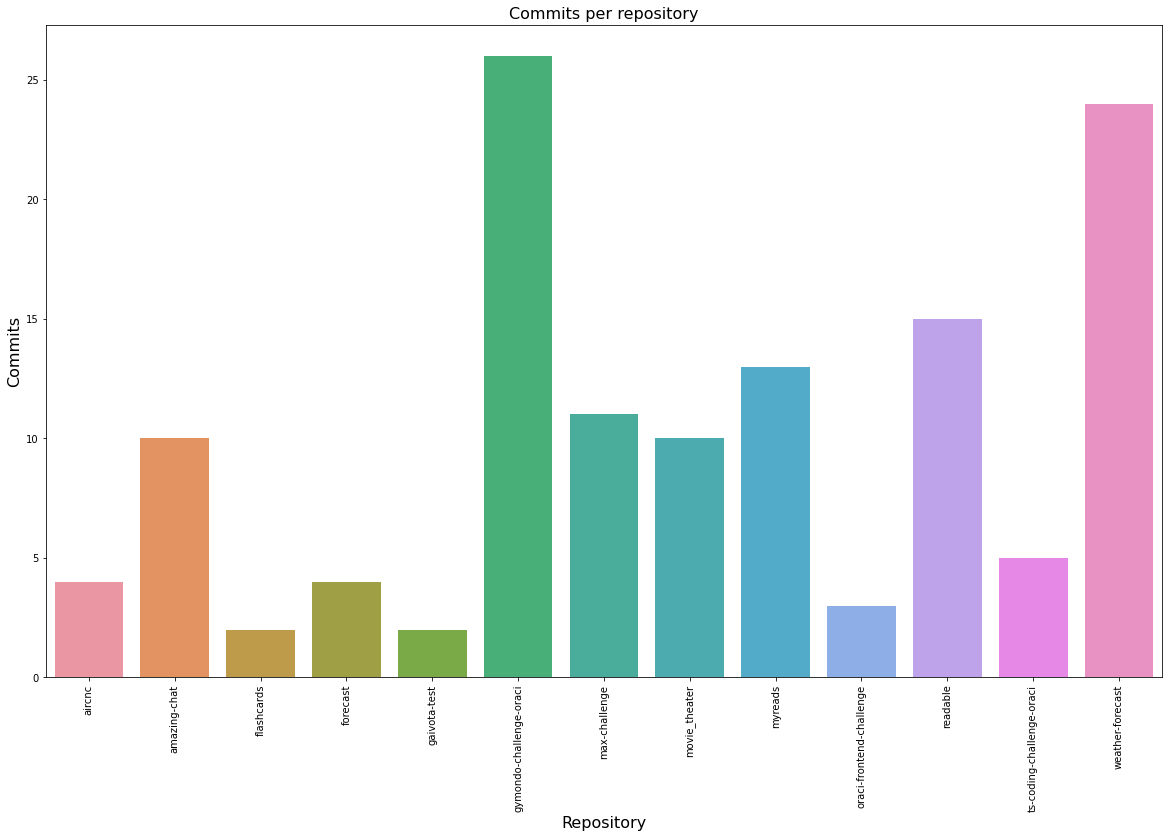

In [18]:
plt.figure(figsize = (20, 12))
sns.barplot(repos['Name'], repos['Commits count'])
plt.xticks(rotation = 90)
plt.xlabel("Repository", fontsize = 16)
plt.ylabel("Commits", fontsize = 16)
plt.title("Commits per repository", fontsize = 16)

In [19]:
commits['Year'] = commits['Date'].apply(lambda x: x.split('-')[0])
yearly_stats = commits.groupby('Year').count()['Commit Id']

/home/gsdenys/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Commits in each year')

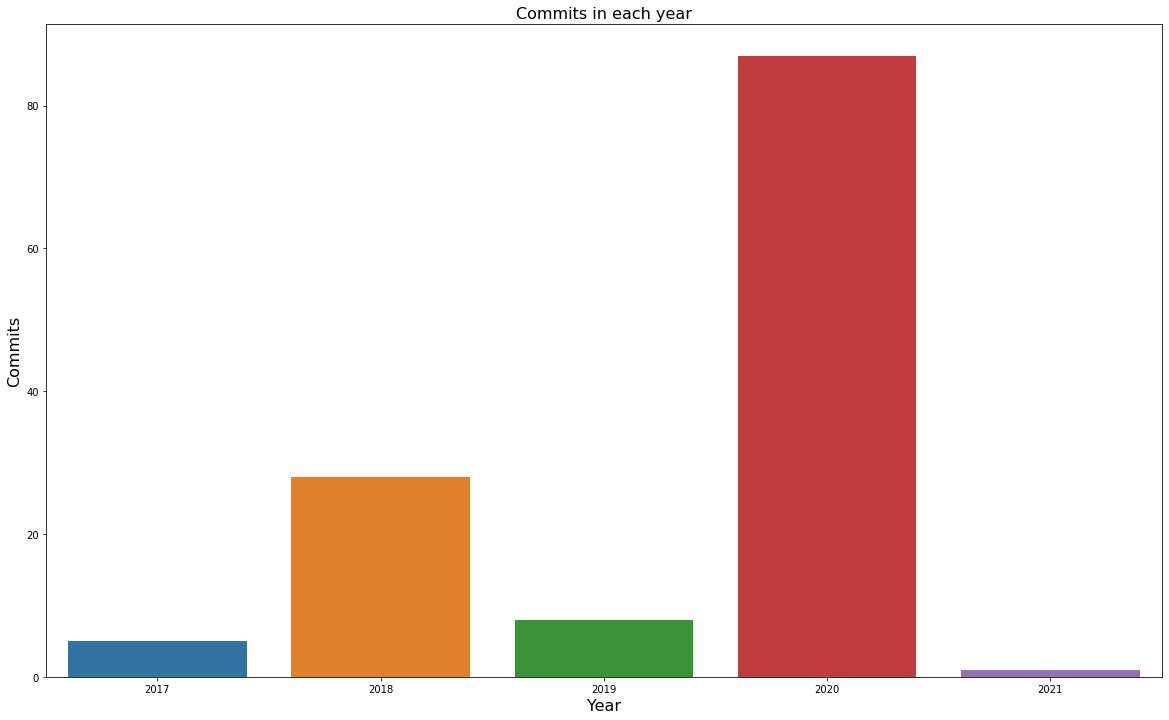

In [20]:
plt.figure(figsize = (20, 12))
sns.barplot(yearly_stats.index, yearly_stats.values)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Commits", fontsize = 16)
plt.title("Commits in each year", fontsize = 16)

In [25]:
commits['Month'] = commits['Date'].apply(lambda x: x.split('-')[1])
monthly_stats = commits[commits['Year'] == '2020'].groupby('Month').count()['Commit Id']

/home/gsdenys/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Commits in each month of 2020')

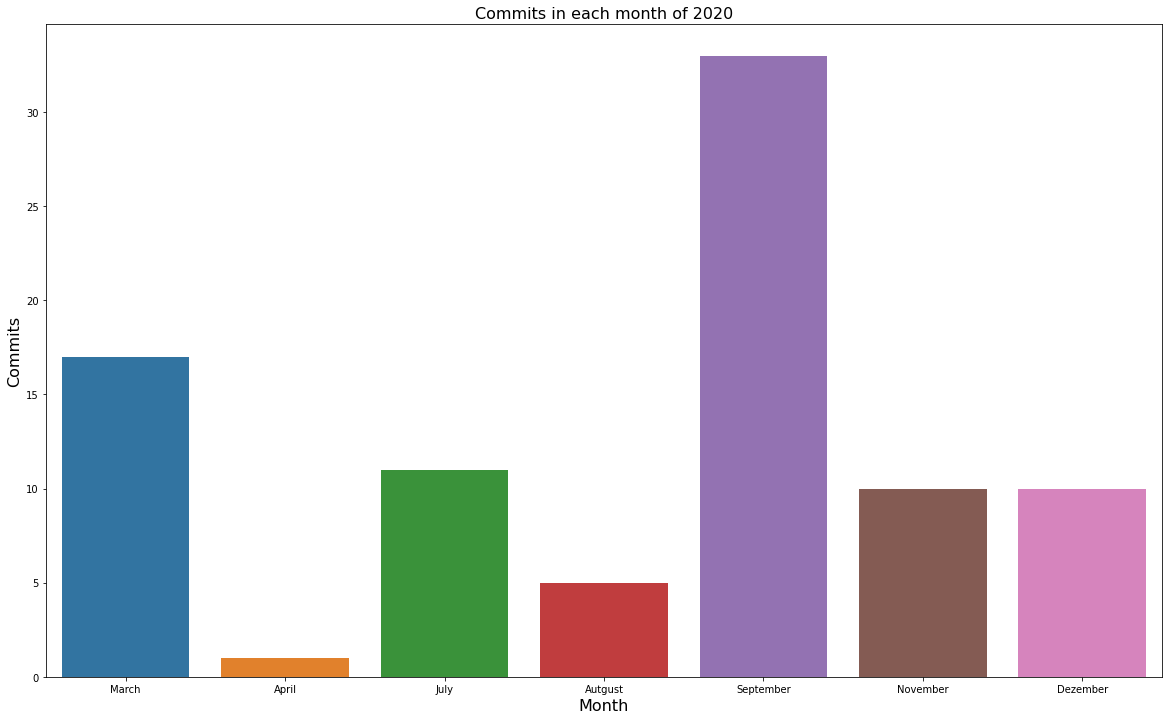

In [26]:
month_mapper = { '01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May', '06': 'June', '07': 'July', '08': 'Autgust', '09': 'September','10': 'October', '11':'November', '12': 'Dezember'}
labels = []
for value in monthly_stats.index:
    labels.append(month_mapper[value])

plt.figure(figsize = (20, 12))
plot = sns.barplot(monthly_stats.index, monthly_stats.values)
plt.xlabel("Month", fontsize = 16)
plot.set_xticklabels(labels)
plt.ylabel("Commits", fontsize = 16)
plt.title("Commits in each month of 2020", fontsize = 16)

In [27]:
commits['Date only'] = pd.to_datetime(commits['Date'].apply(lambda date: date.split('T')[0]))
commit_stats = commits[(commits['Year'] == '2020')
                       & (commits['Month'] == '09')]['Date only'].value_counts().sort_index()

/home/gsdenys/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Commits in March, 2019')

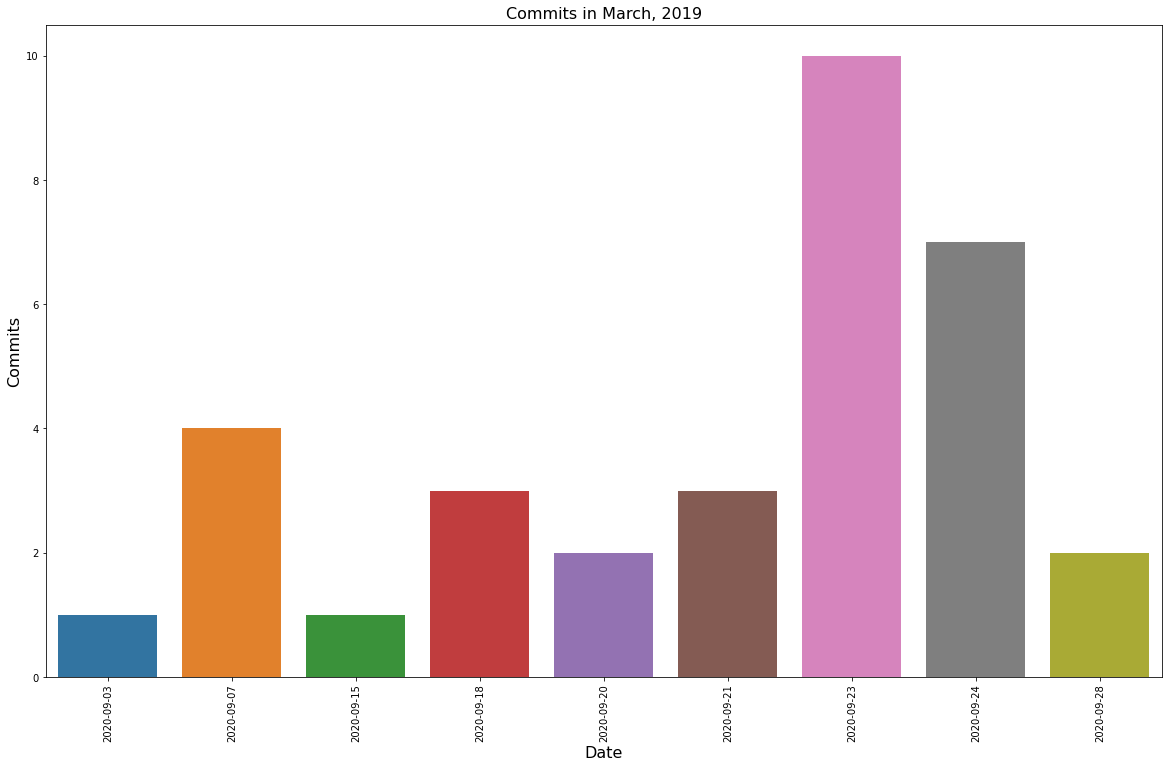

In [28]:
labels = []
for value in commit_stats.index:
    labels.append(value.date())
    
plt.figure(figsize = (20, 12))
plot = sns.barplot(commit_stats.index, commit_stats.values)
plt.xlabel("Date", fontsize = 16)
plt.xticks(rotation = 90)
plot.set_xticklabels(labels)
plt.ylabel("Commits", fontsize = 16)
plt.title("Commits in March, 2019", fontsize = 16)

## Language

In [29]:
list_of_languages = []
for languages in repos['Languages']:
    if type(languages) == str:
        for language in languages.split(','):
            list_of_languages.append(language.strip())

/home/gsdenys/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Language distribution amongst all repositories')

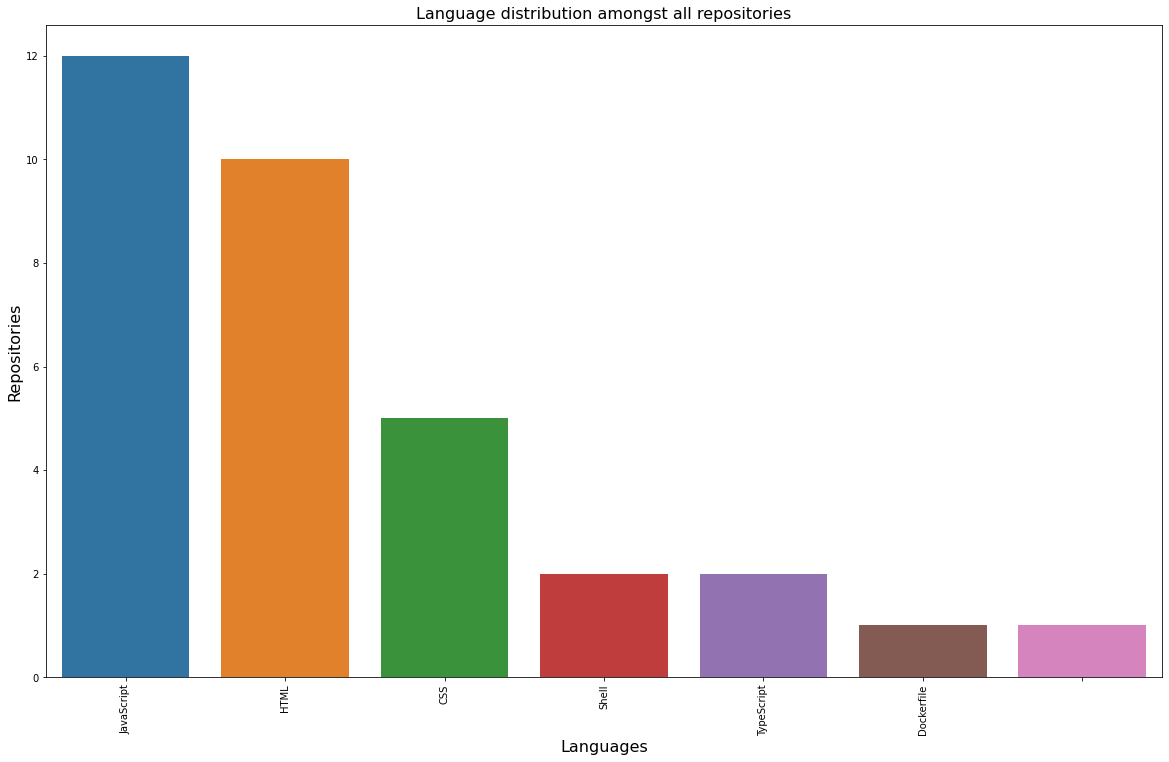

In [30]:
languages_count = pd.Series(list_of_languages).value_counts()

plt.figure(figsize = (20, 12))
sns.barplot(languages_count.index, languages_count.values)
plt.xlabel("Languages", fontsize = 16)
plt.xticks(rotation = 90)
plt.ylabel("Repositories", fontsize = 16)
plt.title("Language distribution amongst all repositories", fontsize = 16)